12.427172647627055, -0.1006927430708789 .
Episode 0, Total Reward: 3.00, Steps: 9
12.657423576987254, -0.14639511199153069 .
Episode 10, Total Reward: 2.00, Steps: 4
15.238488952133617, 0.17114496107176097 .
Episode 20, Total Reward: 3.00, Steps: 6
12.657423576987254, 0.14639511199153069 .
Episode 30, Total Reward: 2.00, Steps: 4
12.657423576987254, 0.14639511199153069 .
Episode 40, Total Reward: 2.00, Steps: 4
12.657423576987254, 0.14639511199153069 .
Episode 50, Total Reward: 2.00, Steps: 4
18.415692341441208, 0.21911473610514665 .
Episode 60, Total Reward: 5.00, Steps: 7
12.657423576987254, 0.14639511199153069 .
Episode 70, Total Reward: 2.00, Steps: 4
12.657423576987254, 0.14639511199153069 .
Episode 80, Total Reward: 2.00, Steps: 4
15.238488952133617, 0.17114496107176097 .
Episode 90, Total Reward: 3.00, Steps: 6
14.37692952337322, 1.1948071894061045 .
Episode 100, Total Reward: 24.00, Steps: 51
12.613786530291296, 0.07806488599907573 .
Episode 110, Total Reward: 3.00, Steps: 11
1

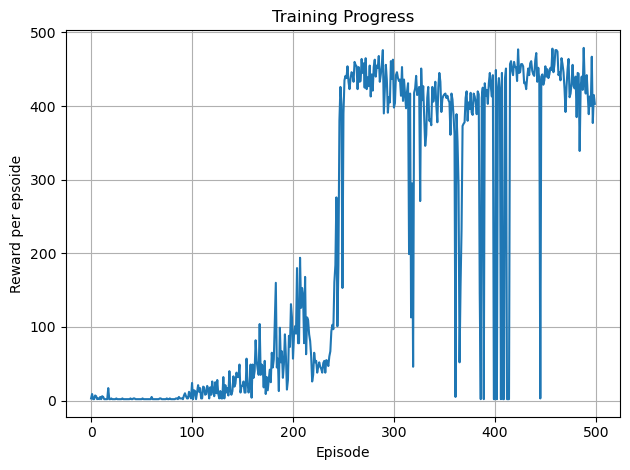

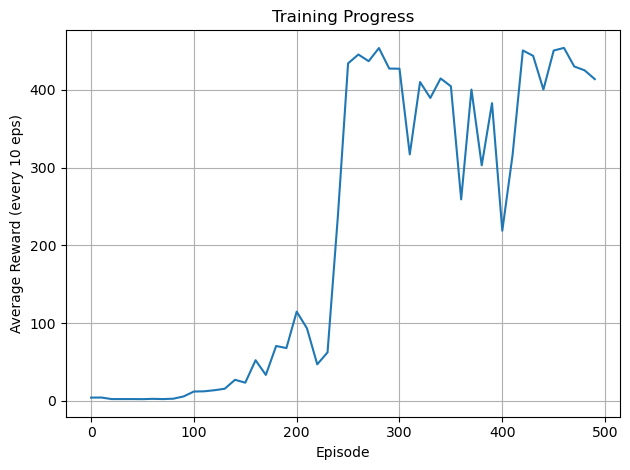

In [74]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
# Custom Cart-Pole Environment (nonlinear dynamics)
class NonlinearCartPoleEnv:
    def __init__(self, dt=0.05):
        self.M = 1.0
        self.m = 0.1
        self.l = 0.5
        self.g = 9.81
        self.dt = dt
        self.force_mag = 10.0
        self.theta_threshold = 12 * np.pi / 180
        self.theta_zero_margin = 2 * np.pi / 180
        self.x_threshold = 2.4
        self.max_theta_dot = 12 * np.pi / 180
        self.warmup_steps = 100
 
    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 0.0])  # [x, x_dot, theta, theta_dot]
        self.steps = 0
        return self.state

    def step(self, action):
        F = self.force_mag if action == 1 else -self.force_mag
        x, x_dot, theta, theta_dot = self.state
        M, m, l, g = self.M, self.m, self.l, self.g

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        denom = M + m

        temp = (F + m * l * theta_dot**2 * sin_theta) / denom

        x_ddot = temp - (m * l * cos_theta / denom) * (
            (g * sin_theta - cos_theta * temp) / (l * (4/3 - m * cos_theta**2 / denom))
        )

        theta_ddot = (g * sin_theta - cos_theta * temp) / (
            l * (4/3 - m * cos_theta**2 / denom)
        )

        # Euler Integration
        x += x_dot * self.dt
        x_dot += x_ddot * self.dt
        theta += theta_dot * self.dt
        theta_dot += theta_ddot * self.dt
        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1

        

        return self.state

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return torch.clamp(x, 1e-8, 1.0)  # Clamp to prevent zero/NaN probs

def is_terminal(state, step_count):
    x, x_dot, theta, theta_dot = state
    theta_deg = math.degrees(theta)
    theta_deg = theta_deg % 360
    if theta_deg > 180 :
        theta_deg = theta_deg-360
   
    return abs(theta_deg) > 12 or abs(x) > 2.4 
# Action selection
def select_action(policy, state):
    state_tensor = torch.tensor(state, dtype=torch.float32)
    probs = policy(state_tensor)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

# Training Loop
env = NonlinearCartPoleEnv()
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
episode_rewards = []
num_episodes = 500
for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    step_count = 0  # Track steps
    done = False

    while not done:
        action, log_prob = select_action(policy, state)
        next_state = env.step(action)

        # Custom termination condition
        done = is_terminal(next_state, step_count)

        # Reward shaping
        theta_deg = abs(math.degrees(next_state[2]))
        pos = next_state[0]
        theta_deg = theta_deg % 360
        if theta_deg > 180 :
            theta_deg = theta_deg-360
        theta_deg = abs(theta_deg)
        if theta_deg <4:
            reward = 1
        else:
            reward = 0
        
        

        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state
        step_count += 1

        if step_count > 500:  # optional max steps
            done = True
    
    # Compute returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + G
        returns.insert(0, G)
    #returns = torch.tensor(returns)
    #if len(returns) > 1:
    #    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    returns = torch.tensor(returns, dtype=torch.float32)  # Ensure it's float from the start

    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # Loss
    loss = -torch.sum(torch.stack(log_probs) * returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    episode_rewards.append(sum(rewards))

    if episode % 10 == 0:
        print(f"{theta_deg}, {pos} .")
        total_reward = sum(rewards)
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Steps: {step_count}")

# Plot
plt.plot(range(0, num_episodes, 1), [(episode_rewards[i]) for i in range(0, num_episodes, 1)])
plt.xlabel("Episode")
plt.ylabel("Reward per epsoide")
plt.title("Training Progress")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.plot(range(0, 500, 10), [np.mean(episode_rewards[i:i+10]) for i in range(0, 500, 10)])
plt.xlabel("Episode")
plt.ylabel("Average Reward (every 10 eps)")
plt.title("Training Progress")
plt.grid(True)
plt.tight_layout()
plt.show()